In [110]:
using Yao
using Statistics: mean
using LinearAlgebra
using Plots

## Build a quantum circuit inspired by MPS

Hadamard Gate with dashed box is applied only when measuring on the X basis.
<div style="display:inline-block"><img style="float: left", src="hgate.png" width="50"/></div>

The following notation measure Measure and Reset a qubit to 0.

<div style="display:inline-block"><img style="float:left", src="mreset.png" width="100"></div>

The goal of this section is to build the MPS-inspired sampler as our ansatz

<div style="display:inline-block"><img style="float:left", src="twoqubit.png"></div>

In [66]:
rotor(noleading::Bool=false, notrailing::Bool=false) = noleading ? (notrailing ? Rx(0) : chain(Rx(0), Rz(0))) : (notrailing ? chain(Rz(0), Rx(0)) : chain(Rz(0), Rx(0), Rz(0)))

"""
    twoqubit_circuit(nlayer::Int, nrepeat::Int)

Construct the above ansatz, `nrepeat` is the number of measure operations,
`nlayer` is the length of each block.
"""
function twoqubit_circuit(nlayer::Int, nrepeat::Int)
    nbit_measure = nbit_virtual = 1
    nbit_used = nbit_measure + nbit_virtual
    circuit = chain(nbit_used)

    for i=1:nrepeat
        unit = chain(nbit_used)
        for j=1:nlayer
            push!(unit, put(nbit_used, 1=>rotor(true, false)))
            push!(unit, control(nbit_used, 1, 2=>(j%2==1 ? X : Z)))
            j == nlayer && push!(unit, put(nbit_used, 1=>rotor(true, true)))
        end
        push!(unit, Measure{nbit_used, 1, AbstractBlock}(Z, (1,), 0, false))
        if i==nrepeat
            for k=2:nbit_used
                push!(unit, Measure{nbit_used, 1, AbstractBlock}(Z, (k,), 0, false))
            end
        end
        push!(circuit, unit)
    end
    dispatch!(circuit, :random)
end

twoqubit_circuit

In [51]:
circuit = twoqubit_circuit(2, 3)

nqubits: 2, datatype: Complex{Float64}
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.28471451835422834)
│  │     └─ rot(Z gate, 0.1324930401020381)
│  ├─ control(1)
│  │  └─ (2,)X gate
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.7917831979745091)
│  │     └─ rot(Z gate, 0.4758247160838598)
│  ├─ control(1)
│  │  └─ (2,)Z gate
│  ├─ put on (1)
│  │  └─ rot(X gate, 0.03394354689385248)
│  └─ Measure{2,1,AbstractBlock}
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.7428559486648305)
│  │     └─ rot(Z gate, 0.4420842120194748)
│  ├─ control(1)
│  │  └─ (2,)X gate
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.19858579409999022)
│  │     └─ rot(Z gate, 0.6718735698455089)
│  ├─ control(1)
│  │  └─ (2,)Z gate
│  ├─ put on (1)
│  │  └─ rot(X gate, 0.9055907558411531)
│  └─ Measure{2,1,AbstractBlock}
└─ chain
   ├─ put on (1)
   │  └─ chain
   │     ├─ rot(X gate, 0.5240466155659402)
   │     └─ rot(Z gate, 0.9359955626846

In [68]:
"""
    gensample(circuit, operator; nbatch=1024) -> Vector of Measure

Generate samples from MPS-inspired circuit. Here, `nbatch` means nshot.
`operator` is the operator to measure.
This function returns a vector of `Measure` gates, results are stored in `m.results`.
"""
function gensample(circuit, operator; nbatch=1024)
    mblocks = collect_blocks(Measure, circuit)
    for m in mblocks
        m.operator = operator
    end
    reg = zero_state(nqubits(circuit); nbatch=nbatch)
    reg |> circuit
    mblocks
end

gensample

In [53]:
res = gensample(circuit, X; nbatch=1024)

4-element Array{Measure,1}:
 Measure{2,1,AbstractBlock}
 Measure{2,1,AbstractBlock}
 Measure{2,1,AbstractBlock}
 Measure{2,1,AbstractBlock}

In [54]:
res[1].results

1024-element Array{Int64,1}:
 -1
 -1
  1
  1
 -1
  1
  1
  1
 -1
 -1
  1
  1
 -1
  ⋮
  1
  1
 -1
 -1
  1
  1
  1
  1
  1
 -1
  1
  1

## Transverse field Ising Hamiltonian

$H = \sum\limits_{i=1}^{N-1} s_i^z s^z_{i+1} + h\sum\limits^{N}_{i=1} s_i^x$

where $s^\alpha = \frac 1 2 \sigma^\alpha$ is the spin operator.

In [70]:
"""
transverse field ising model, `h` is the strength of transverse field.
"""
struct TFIChain
    length::Int
    h::Float64
    TFIChain(length::Int; h::Real) = new(length, Float64(h))
end

TFIChain

In [71]:
model = TFIChain(4; h=0.5)

TFIChain(4, 0.5)

The energy can be estimated through sampling

In [73]:
function energy(circuit, model::TFIChain; nbatch=1024)
    # measuring Z
    mblocks = gensample(circuit, Z; nbatch=nbatch)
    local eng = 0.0
    for (a, b, v) in ((i, i+1, 1.0) for i=1:model.length-1)
        eng += v*mean(mblocks[a].results .* mblocks[b].results)
    end
    eng/=4

    # measuring X
    mblocks = gensample(circuit, X; nbatch=nbatch)
    engx = sum(mean.([m.results for m in mblocks]))
    eng + model.h*engx/2
end

energy (generic function with 1 method)

In [74]:
energy(circuit, model)

-1.1201171875

# Build the expanded view

The expanded view is the equivalent model without qubit reusing, it is used for testing purpose.
From this circuit, we are able to obtain the ground state wave function directly.

<div style="display:inline-block"><img style="float:left", src="fourqubit.png"></div>

In [75]:
function chem2circuit(circuit)
    nbit = length(collect_blocks(Measure, circuit))
    nm = 1
    nv = 1
    c = chain(nbit)
    for (i, blk) in enumerate(circuit)
        blk = chain([b for b in blk if !(b isa Measure)]...)
        push!(c, concentrate(nbit, blk, [(i-1)*nm+1:i*nm..., nbit-nv+1:nbit...]))
    end
    c
end

chem2circuit (generic function with 1 method)

In [76]:
bigc = chem2circuit(circuit)

nqubits: 4, datatype: Complex{Float64}
chain
├─ Concentrator: (1, 4)
│  └─ chain
│     ├─ put on (1)
│     │  └─ chain
│     │     ├─ rot(X gate, 0.10160904960422874)
│     │     └─ rot(Z gate, 0.4859598369770371)
│     ├─ control(1)
│     │  └─ (2,)X gate
│     ├─ put on (1)
│     │  └─ chain
│     │     ├─ rot(X gate, 1.03377538547451)
│     │     └─ rot(Z gate, -1.1808403229786395)
│     ├─ control(1)
│     │  └─ (2,)Z gate
│     └─ put on (1)
│        └─ rot(X gate, -0.5784343827936468)
├─ Concentrator: (2, 4)
│  └─ chain
│     ├─ put on (1)
│     │  └─ chain
│     │     ├─ rot(X gate, 2.592514151789829)
│     │     └─ rot(Z gate, 0.5505558917069752)
│     ├─ control(1)
│     │  └─ (2,)X gate
│     ├─ put on (1)
│     │  └─ chain
│     │     ├─ rot(X gate, 1.3653338409749896)
│     │     └─ rot(Z gate, -0.6880141254669889)
│     ├─ control(1)
│     │  └─ (2,)Z gate
│     └─ put on (1)
│        └─ rot(X gate, 1.4370360683411523)
└─ Concentrator: (3, 4)
   └─ chain
      ├─ put on (1

Construct the hamiltonian using operator arithmatics.

In [79]:
"""
The Hamiltonian of a model.
"""
function hamiltonian(model::TFIChain)
    nbit = model.length
    sum(repeat(nbit, Z, (i,i+1)) for i=1:nbit-1)*0.25 +
    sum(put(nbit, i=>X) for i=1:nbit)*0.5model.h
end

hamiltonian

In [80]:
h = hamiltonian(model)

nqubits: 4, datatype: Complex{Float64}
sum
├─ [scale: 0.25] sum
│     ├─ repeat on (1, 2)
│     │  └─ Z gate
│     ├─ repeat on (2, 3)
│     │  └─ Z gate
│     └─ repeat on (3, 4)
│        └─ Z gate
└─ [scale: 0.25] sum
      ├─ put on (1)
      │  └─ X gate
      ├─ put on (2)
      │  └─ X gate
      ├─ put on (3)
      │  └─ X gate
      └─ put on (4)
         └─ X gate


In [81]:
expect(h, zero_state(nqubits(bigc)) |> bigc) |> real

-1.1221441001568155

## Obtaining the ground state

Sequential optimization
1. obtain the gradient of one parameter a time $\frac{\partial E_\theta}{\partial \theta} = \frac 1 2 (E_{\theta+\pi/2}-E_{\theta-\pi/2})$
2. perform gradient descent update of this parameter $\theta\rightarrow \theta-\alpha \frac{\partial E_\theta}{\partial \theta}$
3. sweep all parameters until convergence.

In [90]:
function train(circuit, model; maxiter=100, α=0.3, nbatch=1024)
    rots = collect_blocks(RotationGate, circuit)
    loss_history = Float64[]
    for i in 0:maxiter
        for r in rots
            r.theta += π/2
            E₊ = energy(circuit, model; nbatch=nbatch)
            r.theta -= π
            E₋ = energy(circuit, model; nbatch=nbatch)
            r.theta += π/2
            g = 0.5(E₊ - E₋)
            r.theta -= g*α
        end
        push!(loss_history, energy(circuit, model, nbatch=nbatch)/model.length)
        i%10 ==0 && println("Iter $i, E/N = $(loss_history[end])")
    end
    loss_history, circuit
end

train (generic function with 1 method)

In [91]:
dispatch!(circuit, :random)
loss_history, circuit = train(circuit, model);

Iter 0, E/N = 0.0445556640625
Iter 10, E/N = -0.083251953125
Iter 20, E/N = -0.1195068359375
Iter 30, E/N = -0.1795654296875
Iter 40, E/N = -0.264892578125
Iter 50, E/N = -0.2763671875
Iter 60, E/N = -0.2813720703125
Iter 70, E/N = -0.2725830078125
Iter 80, E/N = -0.2779541015625
Iter 90, E/N = -0.27685546875
Iter 100, E/N = -0.27783203125


In [92]:
# obtain the exact ground state energy
EG = eigen(mat(h) |> Matrix).values[1]
@show EG/nspin

EG / nspin = -0.29742315519647605


-0.29742315519647605

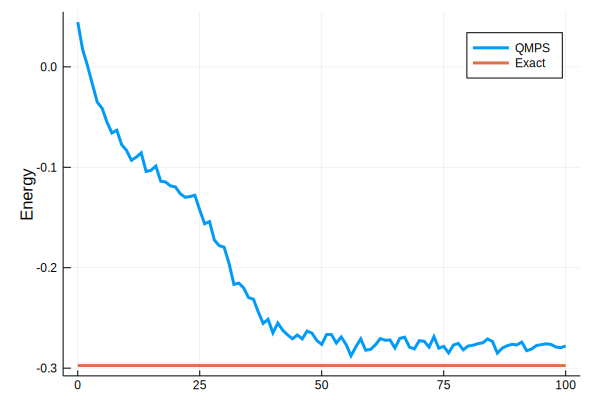

In [109]:
plot(0:100, [loss_history, fill(EG/4, 101)], label=["QMPS", "Exact"], lw=3, ylabel="Energy")

## Entanglement Entropy

In [23]:
EV = eigen(mat(h) |> Matrix).vectors[:,1]

16-element Array{Complex{Float64},1}:
  0.10878394077769024 + 0.0im
  -0.1666666666666665 + 0.0im
 -0.25534814770632663 + 0.0im
  0.14656420692863603 + 0.0im
  -0.2553481477063265 + 0.0im
   0.4798975402619696 + 0.0im
  0.22454939255564377 + 0.0im
  -0.1666666666666668 + 0.0im
 -0.16666666666666657 + 0.0im
  0.22454939255564235 + 0.0im
  0.47989754026197007 + 0.0im
  -0.2553481477063253 + 0.0im
    0.146564206928636 + 0.0im
  -0.2553481477063251 + 0.0im
  -0.1666666666666669 + 0.0im
  0.10878394077768962 - 0.0im

In [32]:
reg = ArrayReg(EV)

ArrayReg{1, Complex{Float64}, Array...}
    active qubits: 4/4

In [33]:
r = reg |> focus!(1, 2) |> ρ

DensityMatrix{1,Complex{Float64},Array{Complex{Float64},3}}
    active qubits: 2/2

In [39]:
entropy(spectrum) = -sum(spectrum .* log.(spectrum))/log(2)

entropy (generic function with 1 method)

In [40]:
entropy(eigen(r.state[:,:,1]).values)

0.41098665651454297